#### The purpose of this notebook is to compare D-REPR with other methods such as KR2RML and R2RML in term of performance

In [1]:
import re, numpy as np, csv, ujson
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
from collections import defaultdict
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [12]:
wdir = Path("/workspace/temp")
runtime = defaultdict(lambda: defaultdict(lambda: []))

In [5]:
def read_exec_time(log_file: str, tag_str: str='>>> [DREPR]', print_exec_time: bool=True):
    """Read the executing time of the program"""
    exec_times = []
    with open(log_file, "r") as f:
        for line in f:
            if line.find(tag_str) != -1:
                m = re.search("((?:\d+\.)?\d+) ?ms", line)
                if m is None:
                    m = re.search("((?:\d+\.)?\d+) ?seconds", line)
                    exec_time = float(m.group(1)) * 1000
                else:
                    exec_time = float(m.group(1))
                    
                exec_times.append(exec_time)
                if print_exec_time:
                    print(line.strip(), "-- extract exec_time:", exec_times[-1])
    
    if len(exec_times) == 0:
        raise Exception("Doesn't found any output message")
        
    assert len(exec_times) == 1, exec_times
    return float(exec_times[0])

#### Generate benchmark data

In [78]:
n_records = 5000 * 2 * 2 * 2 * 2

benchmark_dir = wdir / "benchmark_datasets" / "people80k"
benchmark_dir.mkdir(exist_ok=True)

with open(benchmark_dir / "DATA.csv", "w") as f:
    writer = csv.writer(f)
    header = ["ID", "NAME", "PHONE", "STREET", "CITY", "STATE", "ZIPCODE"]
    writer.writerow(header)
    
    for i in tqdm(range(n_records)):
        writer.writerow([f"http://example.org/people/{i}", f"name_{i}", f"phone_{i}", f"street_{i}", f"city_{i}", f"state_{i}", f"zipcode_{i}"])

In [13]:
people_dataset = wdir / "benchmark_datasets" / "people10k"
n_runs = 3

#### KR2RML

To setup KR2RML, we need to first download Web-Karma-2.2 from the web, modify the file: `karma-offline/src/main/java/edu/isi/karma/rdf/OfficeRDFGenerator` to add this code to line 184: `System.out.println(">>> [DREPR] Finish converting RDF after " + String.valueOf(System.currentTimeMillis() - l) + "ms");` to print the runtime to stdout.

Then run `mvn install -Dmaven.test.skip=true` at the root directory to install dependencies before actually converting data to RDF

In [80]:
%cd /workspace/tools-evaluation/Web-Karma-2.2/karma-offline

DATA_FILE = people_dataset / "DATA.csv"
MODEL_FILE = people_dataset / "karma.model.ttl"
OUTPUT_FILE = people_dataset / "karma.output.ttl"
print(DATA_FILE)

karma_exec_times = []

for i in tqdm(range(n_runs)):
    !mvn exec:java -Dexec.mainClass="edu.isi.karma.rdf.OfflineRdfGenerator" -Dexec.args=" \
        --sourcetype CSV \
        --filepath \"{DATA_FILE}\" \
        --modelfilepath \"{MODEL_FILE}\" \
        --sourcename test \
        --outputfile {OUTPUT_FILE}" -Dexec.classpathScope=compile > /tmp/karma_speed_comparison.log
    
    karma_exec_times.append(read_exec_time("/tmp/karma_speed_comparison.log"))
    !rm /tmp/karma_speed_comparison.log
        
print(f"run {n_runs} times, average: {np.mean(karma_exec_times)}ms")

/workspace/tools-evaluation/Web-Karma-2.2/karma-offline
/workspace/drepr/drepr-exp/benchmark_datasets/people80k/DATA.csv


init: Bootstrapping class not in Py.BOOTSTRAP_TYPES[class=class org.python.core.PyStringMap]
>>> [DREPR] Finish converting RDF after 8471ms -- extract exec_time: 8471.0
init: Bootstrapping class not in Py.BOOTSTRAP_TYPES[class=class org.python.core.PyStringMap]
>>> [DREPR] Finish converting RDF after 8434ms -- extract exec_time: 8434.0
init: Bootstrapping class not in Py.BOOTSTRAP_TYPES[class=class org.python.core.PyStringMap]
>>> [DREPR] Finish converting RDF after 8011ms -- extract exec_time: 8011.0

run 3 times, average: 8305.333333333334ms


<hr />

Report information about the output and input

In [81]:
with open(DATA_FILE, "r") as f:
    n_records = sum(1 for _ in f) - 1
    print("#records:", n_records, f"({round(n_records * 1000 / np.mean(karma_exec_times), 2)} records/s)")
with open(OUTPUT_FILE, "r") as f:
    n_triples = sum(1 for line in f if line.strip().endswith("."))
    print("#triples:", n_triples, f"({round(n_triples * 1000 / np.mean(karma_exec_times), 2)} triples/s)")

#records: 80000 (9632.36 records/s)
#triples: 720000 (86691.28 triples/s)


In [82]:
runtime['karma'][n_records] = karma_exec_times
print(ujson.dumps(runtime, indent=4))

{
    "karma":{
        "5000":[
            1475.0,
            1408.0,
            1221.0
        ],
        "10000":[
            1797.0,
            1765.0,
            1767.0
        ],
        "20000":[
            3199.0,
            3053.0,
            3578.0
        ],
        "40000":[
            5213.0,
            4807.0,
            4951.0
        ],
        "80000":[
            8471.0,
            8434.0,
            8011.0
        ]
    },
    "morph":{
        "5000":[
            5113.0,
            5035.0,
            4288.0
        ],
        "10000":[
            14860.0,
            15249.0,
            14740.0
        ],
        "20000":[
            60142.0,
            71170.0,
            66572.0
        ]
    },
    "drepr":{
        "5000":[
            33.04,
            33.67,
            33.6
        ],
        "10000":[
            69.16,
            66.19,
            74.17
        ],
        "20000":[
            134.05,
            130.07,
          

#### MorphRDB

Assuming that you have followed their installation guides at [this](https://github.com/oeg-upm/morph-rdb/wiki/Installation) and [usages](https://github.com/oeg-upm/morph-rdb/wiki/Usage#csv-files). We are going to create r2rml mappings and invoke their program to map data into RDF

In [65]:
# %cd /workspace/tools-evaluation/morph-rdb/morph-examples
%cd /workspace/drepr/drepr-exp/mappers/morph

morph_exec_time = []
for i in tqdm(range(n_runs)):
    !java -cp .:morph-rdb-dist-3.9.17.jar:dependency/\* es.upm.fi.dia.oeg.morph.r2rml.rdb.engine.MorphCSVRunner {str(people_dataset)} morph.model.properties > /tmp/morph.run.log 2>&1
    morph_exec_time.append(read_exec_time("/tmp/morph.run.log", "Running time = "))
    !rm /tmp/morph.run.log
        
print(f"run {n_runs} times, average: {np.mean(morph_exec_time)}ms")

/workspace/drepr/drepr-exp/mappers/morph


[main] INFO es.upm.fi.dia.oeg.morph.r2rml.rdb.engine.MorphCSVRunner - Running time = 60142 ms. -- extract exec_time: 60142.0
[main] INFO es.upm.fi.dia.oeg.morph.r2rml.rdb.engine.MorphCSVRunner - Running time = 71170 ms. -- extract exec_time: 71170.0
[main] INFO es.upm.fi.dia.oeg.morph.r2rml.rdb.engine.MorphCSVRunner - Running time = 66572 ms. -- extract exec_time: 66572.0

run 3 times, average: 65961.33333333333ms


In [66]:
runtime['morph'][n_records] = morph_exec_time
print(ujson.dumps(runtime, indent=4))

{
    "karma":{
        "5000":[
            1475.0,
            1408.0,
            1221.0
        ],
        "10000":[
            1797.0,
            1765.0,
            1767.0
        ],
        "20000":[
            3199.0,
            3053.0,
            3578.0
        ]
    },
    "morph":{
        "5000":[
            5113.0,
            5035.0,
            4288.0
        ],
        "10000":[
            14860.0,
            15249.0,
            14740.0
        ],
        "20000":[
            60142.0,
            71170.0,
            66572.0
        ]
    },
    "drepr":{
        "5000":[
            33.04,
            33.67,
            33.6
        ],
        "10000":[
            69.16,
            66.19,
            74.17
        ]
    }
}


#### RML

In [39]:
RML_JAR = wdir / "mappers/rmlmapper-4.4.1-r96.jar"

%cd {people_dataset}

!time java -jar {RML_JAR} -s turtle -m "./rml.model.ttl" -o "./rml.output.ttl" > /tmp/rml.run.log

/workspace/drepr/drepr-exp/benchmark_datasets/people5k
^C


#### D-REPR

In [6]:
%cd {people_dataset}

drepr_exec_times = []

for i in tqdm(range(n_runs)):
    !python -m pydrepr.main -r {people_dataset}/drepr.model.yml -d default={people_dataset}/DATA.csv -o {people_dataset}/drepr.output.ttl > /tmp/drepr.log
    drepr_exec_times.append(read_exec_time("/tmp/drepr.log"))
    !rm /tmp/drepr.log

print(f"run {n_runs} times, average: {np.mean(drepr_exec_times)}ms")

/workspace/drepr/drepr-exp/benchmark_datasets/people10k


>>> [DREPR] runtime: 0.06919 seconds -- extract exec_time: 69.19
>>> [DREPR] runtime: 0.06703 seconds -- extract exec_time: 67.03
>>> [DREPR] runtime: 0.07691 seconds -- extract exec_time: 76.91000000000001

run 3 times, average: 71.04333333333334ms


In [84]:
runtime['drepr'][n_records] = drepr_exec_times
print(ujson.dumps(runtime, indent=4))

{
    "karma":{
        "5000":[
            1475.0,
            1408.0,
            1221.0
        ],
        "10000":[
            1797.0,
            1765.0,
            1767.0
        ],
        "20000":[
            3199.0,
            3053.0,
            3578.0
        ],
        "40000":[
            5213.0,
            4807.0,
            4951.0
        ],
        "80000":[
            8471.0,
            8434.0,
            8011.0
        ]
    },
    "morph":{
        "5000":[
            5113.0,
            5035.0,
            4288.0
        ],
        "10000":[
            14860.0,
            15249.0,
            14740.0
        ],
        "20000":[
            60142.0,
            71170.0,
            66572.0
        ]
    },
    "drepr":{
        "5000":[
            33.04,
            33.67,
            33.6
        ],
        "10000":[
            69.16,
            66.19,
            74.17
        ],
        "20000":[
            134.05,
            130.07,
          

In [85]:
with open(wdir / "benchmark_datasets" / "runtime.json", "w") as f:
    ujson.dump(runtime, f)

In [88]:
avg_runtime = {}
for method in runtime:
    avg_runtime[method] = [[], []]
    for num in runtime[method]:
        avg_runtime[method][0].append(num)
        avg_runtime[method][1].append(np.mean(runtime[method][num]))
        print(method, num, np.mean(runtime[method][num]))

karma 5000 1368.0
karma 10000 1776.3333333333333
karma 20000 3276.6666666666665
karma 40000 4990.333333333333
karma 80000 8305.333333333334
morph 5000 4812.0
morph 10000 14949.666666666666
morph 20000 65961.33333333333
drepr 5000 33.43666666666667
drepr 10000 69.83999999999999
drepr 20000 131.99333333333334
drepr 40000 267.4866666666667
drepr 80000 551.2366666666667


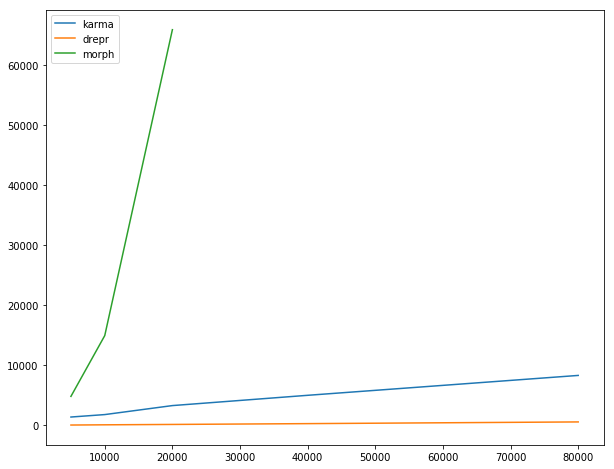

In [95]:

x = np.arange(10)

plt.plot(avg_runtime['karma'][0], avg_runtime['karma'][1])
plt.plot(avg_runtime['drepr'][0], avg_runtime['drepr'][1])
plt.plot(avg_runtime['morph'][0], avg_runtime['morph'][1])
# plt.plot(x, 3 * x)
# plt.plot(x, 4 * x)

plt.legend(['karma', 'drepr', 'morph'], loc='upper left')

plt.show()
